In [1]:
%load_ext autoreload
%autoreload 2
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from data import ModelNet40

data = ModelNet40(num_points=1024, partition='test', )

**************** DATA test = 2468 *****************


euler=[0.67156136 0.07460925 0.03316344]
X:
U:torch.Size([3, 3])
S=tensor([16.4161, 10.2898,  9.7007])
Y:
U:torch.Size([3, 3])
S=tensor([16.4224, 10.3038,  9.7199])
u1_soa=[array([ 0.        ,  0.        ,  0.        ,  0.00368487, -0.01064239,
        1.64157093]), array([ 0.        ,  0.        ,  0.        ,  0.99567842, -0.25961721,
       -0.00391813]), array([0.        , 0.        , 0.        , 0.24477386, 0.93866813,
       0.00553602])]
u2_soa=[array([ 0.        ,  0.        ,  0.        , -0.13135445,  0.05463048,
       -1.63606262]), array([ 0.        ,  0.        ,  0.        ,  0.92408091,  0.45195797,
       -0.05910012]), array([ 0.        ,  0.        ,  0.        ,  0.42288762, -0.8728947 ,
       -0.06309962])]
************************** [solve] START! ******************************
source.shape=torch.Size([3, 1024]), target.shape=torch.Size([3, 1024])
S1=tensor([16.4161, 10.2898,  9.7007])
S2=tensor([16.4224, 10.3038,  9.7199])
S1=tensor([16.4161, 10.2898,  9.7007])


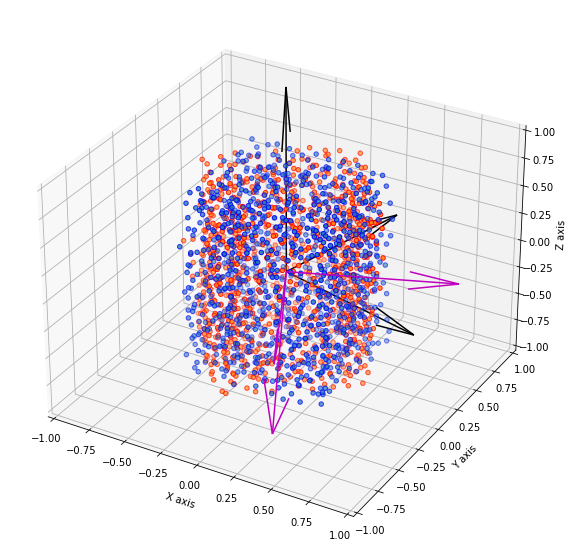

In [3]:
# from util_3d import generate_custom_pointcloud, decompose
from hypericp import torch_solve, torch_compute_components

def decompose(pointcloud):
    return pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]

# pc1, pc2, _, _, _, _, euler, _ = data[352]
# print(data[351])

f = open('debug_hyper-new.npy', 'rb')
pc1 = np.load(f, allow_pickle=True)
pc2 = np.load(f, allow_pickle=True)
# rotation = np.load(f)
euler = np.load(f, allow_pickle=True)
# debug = {
#     'rotation' : rotation,
#     'euler' : euler
# }

print(f'euler={euler}')

# print(f'{np.max(pc1)}')

if True:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # print(f'source={pc1}')

    x1, y1, z1 = decompose(pc1.T)
    x2, y2, z2 = decompose(pc2.T)

    ax.scatter3D(x1, y1, z1, edgecolor='b')
    ax.scatter3D(x2, y2, z2, edgecolor='r')

    (U1, S1), (U2, S2) = torch_compute_components(torch.from_numpy(pc1), torch.from_numpy(pc2))
    
    print(f'X:\nU:{U1.shape}\nS={S1}')
    print(f'Y:\nU:{U2.shape}\nS={S2}')

    u1_soa = []
    for i in range(U1.shape[1]):
        u1_soa.append(np.concatenate([np.asarray([0, 0, 0]), (S1[i] / 10) * U1[:, i]]))

    u2_soa = []
    for j in range(U2.shape[1]):
        u2_soa.append(np.concatenate([np.asarray([0, 0, 0]), (S2[j] / 10) * U2[:, j]]))    


    print(f'u1_soa={u1_soa}')
    print(f'u2_soa={u2_soa}')

    def is_orth(R):
        print(f'RR={R.T @ R}')
        return np.allclose(R.T @ R, np.eye(3))

    def add_soa(soa, c):
        X, Y, Z, U, V, W = zip(*soa)
        ax.quiver(X, Y, Z, U, V, W, color=c)

    add_soa(u1_soa, 'k')
    add_soa(u2_soa, 'm')

    
R, t = torch_solve(torch.from_numpy(pc1), torch.from_numpy(pc2), verbose=True)